In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
import pathlib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [5]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = pathlib.Path('dataset')

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# test_ds = val_ds.take(150)
# val_ds = val_ds.skip(150)

Found 1327 files belonging to 11 classes.
Using 1062 files for training.
Found 1327 files belonging to 11 classes.
Using 265 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['cam_di_nguoc_chieu', 'cam_re_phai', 'cam_re_trai', 'chi_duoc_re_phai', 'chi_duoc_re_trai', 'dung_lai', 'han_che_toc_do_toi_thieu', 'huong_di_phai_phai_theo', 'huong_di_trai_phai_theo', 'toc_do_toi_da_40', 'toc_do_toi_thieu_30']


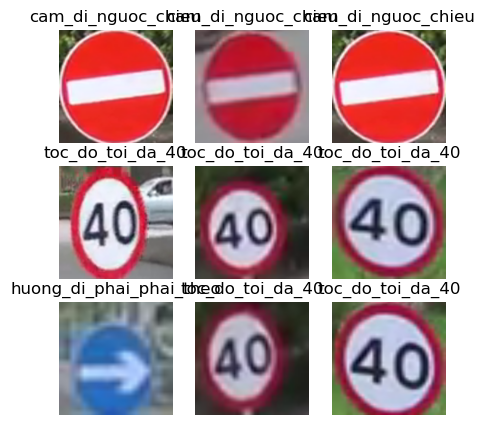

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.15316854 1.0


In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])
data_augmentation.fit

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<bound method TensorFlowTrainer.fit of <Sequential name=sequential, built=True>>

In [14]:
from keras.applications import EfficientNetV2B0
model = EfficientNetV2B0(weights='imagenet', input_shape=(img_width, img_height, 3))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# model.summary()

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/10


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.6991 - loss: 2.1742 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9877 - loss: 0.0362 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 3/10
26/34 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9972 - loss: 0.0179

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model_path = pathlib.Path('model')
model.save(os.path.join(model_path, 'efficient_net_v2_b0.keras'))

In [ ]:
model = keras.models.load_model(os.path.join(model_path, 'efficient_net_v2_b0.keras'))

In [ ]:

img_path = os.path.join(data_dir, 'dung_lai')
img_name = sorted(os.listdir(img_path))[0]
assert os.path.isfile(img_path + '/' + img_name)
with open(img_path + '/' + img_name, 'r') as f:
    pass
img = tf.keras.utils.load_img(
    img_path + '/' + img_name, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
labels = [
    'cam di nguoc chieu',
    'cam re phai',
    'cam re trai',
    'chi duoc re phai',
    'chi duoc re trai',
    'dung lai',
    'han che toc do toi thieu',
    'huong di phai phai theo',
    'huong di trai phai theo',
    'toc do toi da',
    'toc do toi thieu'
]


In [ ]:
_, acc = model.evaluate(val_ds, verbose=1)
print(acc)

In [ ]:
from keras.applications.efficientnet_v2 import decode_predictions
print('Predicted:', decode_predictions(predictions, top=1)[0][0][2])


In [ ]:
img_height = 224
img_width = 224

In [ ]:
from keras.applications import ConvNeXtTiny
model = keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape=(img_width, img_height, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save(os.path.join(model_path, 'convnext.keras'))

In [ ]:
model = keras.models.load_model(os.path.join(model_path, 'convnext.keras'))

In [ ]:

img_path = os.path.join(data_dir, 'dung_lai')
img_name = sorted(os.listdir(img_path))[0]
assert os.path.isfile(img_path + '/' + img_name)
with open(img_path + '/' + img_name, 'r') as f:
    pass
img = tf.keras.utils.load_img(
    img_path + '/' + img_name, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
_, acc = model.evaluate(val_ds, verbose=1)
print(acc)

In [ ]:
from keras.applications.efficientnet_v2 import decode_predictions
print('Predicted:', decode_predictions(predictions, top=1)[0][0][2])
